### Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import pickle

### loading the dataset

In [2]:
df_remax=pd.read_csv('remax_location.csv')

In [3]:
df_star_location=pd.read_csv('properstar_location.csv')
df_star_location_commercial=pd.read_csv('properstar_commercial_location.csv')
df_star=pd.concat([df_star_location,df_star_location_commercial])

## Data exploration

### Properstar data

In [4]:
df_star.head(3)

,statut,link,title,address,prix,Pièces,Etages,Habitable,Climatisation,1,...,Recharge de véhicules électriques,Vue sur les collines,Jardin: vue dégagée,Vue sur la campagne,Vue sur la verdure,Vue du port,Station de ski,Sauna,Orientation Ouest,Orientation Sud
0,Location,https://www.properstar.fr/annonce/102564498,location scolaire S+1 à résidence Tilel,Chott Meriam,196 €,2.0,2.0,60 m²,Climatisation,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Location,https://www.properstar.fr/annonce/102450826,Villa à Louer à Kantaoui - Location Annuelle,Akouda,482 €,3.0,1.0,130 m²,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Location,https://www.properstar.fr/annonce/101457353,location annuelle s+3 à hammam Sousse,Hammam Sousse,451 €,4.0,4.0,100 m²,Climatisation,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_star.shape

(391, 102)

In [6]:
df_star.columns

Index(['statut', 'link', 'title', 'address', 'prix', 'Pièces', 'Etages',
       'Habitable', 'Climatisation', '1',
       ...
       'Recharge de véhicules électriques', 'Vue sur les collines',
       'Jardin: vue dégagée', 'Vue sur la campagne', 'Vue sur la verdure',
       'Vue du port', 'Station de ski', 'Sauna', 'Orientation Ouest',
       'Orientation Sud'],
      dtype='object', length=102)

In [7]:
df_star.isna().sum().sort_values(ascending=True).head(25)

statut                     0
link                       0
prix                       0
title                      2
address                    2
1                         52
Pièces                    55
Type                      80
Habitable                 86
Total                    157
Etages                   180
Meublé                   206
Climatisation            219
Chambres                 223
Salles de bains          225
Chauffage                227
Condition                235
Toilettes                239
Année de construction    239
Alarme                   248
Eau chaude               254
Taxi                     266
Ascenseur                266
Magasins                 268
Centre-ville             274
dtype: int64

In [8]:
columns_to_keep=['address','Type', 'Habitable',
       'Pièces', 'Salles de bains', 'Chambres','Garage','Jardin','Balcon','Meublé','Piscine','Etages', 'prix']
df_star=df_star[columns_to_keep]
df_star.head()

,address,Type,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix
0,Chott Meriam,Appartement,60 m²,2.0,NaN,NaN,NaN,NaN,NaN,Meublé,Piscine,2.0,196 €
1,Akouda,Maison,130 m²,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,482 €
2,Hammam Sousse,Appartement,100 m²,4.0,NaN,NaN,NaN,NaN,NaN,Meublé,NaN,4.0,451 €
3,El Kram,Appartement,140 m²,5.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,1.0,587 €
4,Sousse,Appartement,70 m²,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,211 €


In [9]:
df_star.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 0 to 76
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          389 non-null    object 
 1   Type             311 non-null    object 
 2   Habitable        305 non-null    object 
 3   Pièces           336 non-null    float64
 4   Salles de bains  166 non-null    float64
 5   Chambres         168 non-null    float64
 6   Garage           5 non-null      object 
 7   Jardin           13 non-null     object 
 8   Balcon           76 non-null     object 
 9   Meublé           185 non-null    object 
 10  Piscine          78 non-null     object 
 11  Etages           211 non-null    float64
 12  prix             391 non-null    object 
dtypes: float64(4), object(9)
memory usage: 42.8+ KB


In [10]:
df_star.isna().sum().sort_values(ascending=False)

Garage             386
Jardin             378
Balcon             315
Piscine            313
Salles de bains    225
Chambres           223
Meublé             206
Etages             180
Habitable           86
Type                80
Pièces              55
address              2
prix                 0
dtype: int64

### remax data

In [11]:
df_remax.head(3)

,statut,link,title,prix,address,statut_marche,Nombre de pièces,Nombre de chambres,Nombre salles de bain,m²,...,Energie solaire,Sud,Sud-ouest,Ouest,Vue sur lac,A la campagne,Nord-ouest,Nord-est,Montagnes,Parcelle d'angle
0,Location,https://www.remax.com.tn/fr-tn/biens/maison-in...,Maison individuelle - Location - Djerba - Mido...,"2,000 TND",4116 - Djerba - Midoun - Médenine - Tunisie,Excellente valeur,3.0,2.0,2.0,400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Location,https://www.remax.com.tn/fr-tn/biens/apparteme...,Appartement - Location - L'Aouina Tunis Tunisie,"1,100 TND",L'Aouina - Tunis - Tunisie,Nouveau sur le marché,3.0,2.0,1.0,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Location,https://www.remax.com.tn/fr-tn/biens/apparteme...,Appartement - Location - La Soukra Ariana Tunisie,"1,250 TND",La Soukra - Ariana - Tunisie,Remis à neuf,4.0,3.0,1.0,125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_remax.shape

(218, 126)

In [13]:
df_remax.columns

Index(['statut', 'link', 'title', 'prix', 'address', 'statut_marche',
       'Nombre de pièces', 'Nombre de chambres', 'Nombre salles de bain', 'm²',
       ...
       'Energie solaire', 'Sud', 'Sud-ouest', 'Ouest', 'Vue sur lac',
       'A la campagne', 'Nord-ouest', 'Nord-est', 'Montagnes',
       'Parcelle d'angle'],
      dtype='object', length=126)

In [14]:
df_remax.isna().sum().sort_values(ascending=True).head(15)

statut                         0
link                           0
title                          0
prix                           0
address                        0
Nombre salles de bain         14
Nombre de pièces              17
Nombre de chambres            17
Surface constructible (m²)    23
m²                            27
Année/Mois de Construction    33
Cuisine équipée               44
statut_marche                 58
Nombre d'étages               61
Nombre de WC                  80
dtype: int64

In [15]:
columns_to_keep=['title','address', 'm²',
       'Nombre de pièces', 'Nombre salles de bain', 'Nombre de chambres',
       'Garage','Jardin','Balcon','Meublé','Piscine','Piscine extérieure',"Nombre d'étages", 'prix']
df_remax=df_remax[columns_to_keep]
df_remax.head(3)


,title,address,m²,Nombre de pièces,Nombre salles de bain,Nombre de chambres,Garage,Jardin,Balcon,Meublé,Piscine,Piscine extérieure,Nombre d'étages,prix
0,Maison individuelle - Location - Djerba - Mido...,4116 - Djerba - Midoun - Médenine - Tunisie,400,3.0,2.0,2.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,"2,000 TND"
1,Appartement - Location - L'Aouina Tunis Tunisie,L'Aouina - Tunis - Tunisie,100,3.0,1.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0,"1,100 TND"
2,Appartement - Location - La Soukra Ariana Tunisie,La Soukra - Ariana - Tunisie,125,4.0,1.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,"1,250 TND"


In [16]:
df_remax.rename(columns={
    'm²': 'Habitable',
    'Nombre de chambres':'Chambres',
    'Nombre de pièces':'Pièces',
    'Nombre salles de bain':'Salles de bains',
    "Nombre d'étages":'Etages'
}, inplace=True)
df_remax.head(1)

,title,address,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Piscine extérieure,Etages,prix
0,Maison individuelle - Location - Djerba - Mido...,4116 - Djerba - Midoun - Médenine - Tunisie,400,3.0,2.0,2.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,"2,000 TND"


In [17]:
df_remax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               218 non-null    object 
 1   address             218 non-null    object 
 2   Habitable           191 non-null    object 
 3   Pièces              201 non-null    float64
 4   Salles de bains     204 non-null    float64
 5   Chambres            201 non-null    float64
 6   Garage              55 non-null     float64
 7   Jardin              76 non-null     float64
 8   Balcon              93 non-null     float64
 9   Meublé              114 non-null    float64
 10  Piscine             51 non-null     float64
 11  Piscine extérieure  17 non-null     float64
 12  Etages              157 non-null    float64
 13  prix                218 non-null    object 
dtypes: float64(10), object(4)
memory usage: 24.0+ KB


In [18]:
df_remax['prix'].sample(3)

144    2,200 TND
45     3,000 TND
66     1,500 TND
Name: prix, dtype: object

In [19]:
df_star['prix'].sample(3)

163          0
72           0
3      4 816 €
Name: prix, dtype: object

### Data Preprocessing

### properstar

#### Prix column

In [20]:
#update the price column
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace('€','') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace('\u202f', '') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: str(x).replace(' ','') if isinstance(x, str) else x)
df_star['prix'] = df_star['prix'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df_star['prix'] = pd.to_numeric(df_star['prix'], errors='coerce')

#### Habitable,Total and Terrain

In [21]:
df_star.sample(1)

,address,Type,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix
85,Chott Meriam,Appartement,100 m²,5.0,2.0,2.0,NaN,NaN,Balcon,Meublé,Piscine,4.0,587


In [22]:
def clean_size_column(df, col):
    """
    Cleans a size-related column by:
    1. Removing 'm²' and any non-breaking spaces.
    2. Stripping leading/trailing spaces.
    3. Converting cleaned values to numeric (float).
    4. Handling missing or invalid values gracefully.
    """
    df[col] = df[col].astype(str)  # Convert all to string to prevent errors
    df[col] = df[col].str.replace('m²', '', regex=False)  # Remove 'm²'
    df[col] = df[col].str.replace('\u202f', '', regex=False)  # Remove non-breaking spaces
    df[col] = df[col].str.replace(' ', '', regex=False)  # Remove normal spaces
    df[col] = df[col].str.strip()  # Strip leading/trailing spaces
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float, setting errors to NaN

# Example usage
columns_to_clean = ['Habitable']  # List of size-related columns
for col in columns_to_clean:
    clean_size_column(df_star, col)

# Check the cleaned columns
df_star[columns_to_clean].head()


,Habitable
0,60.0
1,130.0
2,100.0
3,140.0
4,70.0


#### Type column

In [23]:
df_star['Type'] = df_star['Type'].replace({'Appartement': 'Residential','Maison':'Residential'})
df_star['Type'].value_counts()

Type
Residential    289
Commercial      22
Name: count, dtype: int64

### remax

#### title column

In [24]:
df_remax['title'] = df_remax['title'].str.split('-').str[0]
# Remove trailing/leading spaces
df_remax['Type'] = df_remax['title'].str.strip()

# Handle specific cases for "1" and "6 and More"
df_remax = df_remax[ (df_remax['Type']!='6 and More') & (df_remax['Type']!='1') ]

# Optional: categorize property types
def categorize_property(property_type):
    if property_type in ["Appartement", "Villa", "Maison", "Duplex", "Penthouse", "Studio", "Résidence"]:
        return "Residential"
    elif property_type in ["Commercial", "Showroom", "Bureau", "Office", "Local Commercial", "Building"]:
        return "Commercial"
    elif property_type in ["Terrain", "Lot", "Land", "Agricole"]:
        return "Land"
    elif property_type in ["Hôtel", "Warehouse", "Usine", "Entrepôt", "Industrie"]:
        return "Industrial"
    else:
        return "Other"
df_remax['Type'] = df_remax['Type'].apply(categorize_property)
df_remax=df_remax.drop(columns=['title'])
df_remax['Type'].value_counts()

Type
Residential    177
Other           41
Name: count, dtype: int64

#### other columns

In [25]:
df_remax.head(1)

,address,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Piscine extérieure,Etages,prix,Type
0,4116 - Djerba - Midoun - Médenine - Tunisie,400,3.0,2.0,2.0,NaN,1.0,NaN,1.0,1.0,1.0,NaN,"2,000 TND",Other


In [26]:
#change column types
df_remax['Habitable'] = df_remax['Habitable'].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
df_remax['Habitable'] = pd.to_numeric(df_remax['Habitable'], errors='coerce')

df_remax['prix'] = df_remax['prix'].apply(lambda x: str(x).replace('TND','') if isinstance(x, str) else x)
df_remax['prix'] = df_remax['prix'].apply(lambda x: str(x).replace(',','') if isinstance(x, str) else x)
df_remax['prix'] = df_remax['prix'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df_remax['prix'] = pd.to_numeric(df_remax['prix'], errors='coerce')

columns_with_zero=['Garage','Jardin','Balcon','Meublé','Piscine','Piscine extérieure']
for col in columns_with_zero:
    df_remax[col]=df_remax[col].fillna(0)
df_remax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             218 non-null    object 
 1   Habitable           191 non-null    float64
 2   Pièces              201 non-null    float64
 3   Salles de bains     204 non-null    float64
 4   Chambres            201 non-null    float64
 5   Garage              218 non-null    float64
 6   Jardin              218 non-null    float64
 7   Balcon              218 non-null    float64
 8   Meublé              218 non-null    float64
 9   Piscine             218 non-null    float64
 10  Piscine extérieure  218 non-null    float64
 11  Etages              157 non-null    float64
 12  prix                195 non-null    float64
 13  Type                218 non-null    object 
dtypes: float64(12), object(2)
memory usage: 24.0+ KB


In [27]:
df_remax['Piscine'] = df_remax[['Piscine', 'Piscine extérieure']].max(axis=1)

In [28]:
df_remax=df_remax.drop('Piscine extérieure',axis=1)
df_remax.head(1)

,address,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix,Type
0,4116 - Djerba - Midoun - Médenine - Tunisie,400.0,3.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,NaN,2000.0,Other


#### combine the two dataframes into one

In [29]:
df=pd.concat([df_remax,df_star])
print(df.shape)
df.head()

(609, 13)


,address,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix,Type
0,4116 - Djerba - Midoun - Médenine - Tunisie,400.0,3.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,NaN,2000.0,Other
1,L'Aouina - Tunis - Tunisie,100.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,1100.0,Residential
2,La Soukra - Ariana - Tunisie,125.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,1250.0,Residential
3,"Ennasr II, Ariana - 2001 - Ennasr 1-2 - Ariana...",196.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,3000.0,Residential
4,La Marsa - La Marsa - Tunis - Tunisie,60.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2200.0,Residential


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 0 to 76
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          607 non-null    object 
 1   Habitable        496 non-null    float64
 2   Pièces           537 non-null    float64
 3   Salles de bains  370 non-null    float64
 4   Chambres         369 non-null    float64
 5   Garage           223 non-null    object 
 6   Jardin           231 non-null    object 
 7   Balcon           294 non-null    object 
 8   Meublé           403 non-null    object 
 9   Piscine          296 non-null    object 
 10  Etages           368 non-null    float64
 11  prix             586 non-null    float64
 12  Type             529 non-null    object 
dtypes: float64(6), object(7)
memory usage: 66.6+ KB


In [31]:
#this part gets us the latitude and longitude 
geolocator = Nominatim(user_agent="my_unique_app_12345")

def get_coordinates(address):
    try:
        location = geolocator.geocode(address, timeout=10)  # Increase timeout
        if location:
            return pd.Series([location.latitude, location.longitude])
    except GeocoderTimedOut:
        time.sleep(1)  # Wait and retry in case of timeout
        return get_coordinates(address)  # Retry
    return pd.Series([None, None])

df[['Latitude', 'Longitude']] = df['address'].apply(get_coordinates)
df.head()

,address,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix,Type,Latitude,Longitude
0,4116 - Djerba - Midoun - Médenine - Tunisie,400.0,3.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,NaN,2000.0,Other,33.769864,10.944514
1,L'Aouina - Tunis - Tunisie,100.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,1100.0,Residential,36.849148,10.263936
2,La Soukra - Ariana - Tunisie,125.0,4.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,1250.0,Residential,36.874975,10.245427
3,"Ennasr II, Ariana - 2001 - Ennasr 1-2 - Ariana...",196.0,4.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,3.0,3000.0,Residential,NaN,NaN
4,La Marsa - La Marsa - Tunis - Tunisie,60.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2200.0,Residential,36.887333,10.315343


### Data cleaning

In [32]:
df_clean=df.drop(columns=['address'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 609 entries, 0 to 76
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Habitable        496 non-null    float64
 1   Pièces           537 non-null    float64
 2   Salles de bains  370 non-null    float64
 3   Chambres         369 non-null    float64
 4   Garage           223 non-null    object 
 5   Jardin           231 non-null    object 
 6   Balcon           294 non-null    object 
 7   Meublé           403 non-null    object 
 8   Piscine          296 non-null    object 
 9   Etages           368 non-null    float64
 10  prix             586 non-null    float64
 11  Type             529 non-null    object 
 12  Latitude         597 non-null    float64
 13  Longitude        597 non-null    float64
dtypes: float64(8), object(6)
memory usage: 71.4+ KB


In [33]:
df_clean=df_clean.dropna(subset=['prix'])
df_clean.shape

(586, 14)

In [34]:
from sklearn.impute import KNNImputer
# Assuming df is your dataframe
imputer = KNNImputer(n_neighbors=5)  # You can adjust n_neighbors
df_clean[['Latitude', 'Longitude']] = imputer.fit_transform(df_clean[['Latitude', 'Longitude']])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586 entries, 0 to 76
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Habitable        473 non-null    float64
 1   Pièces           514 non-null    float64
 2   Salles de bains  349 non-null    float64
 3   Chambres         348 non-null    float64
 4   Garage           200 non-null    object 
 5   Jardin           208 non-null    object 
 6   Balcon           271 non-null    object 
 7   Meublé           380 non-null    object 
 8   Piscine          273 non-null    object 
 9   Etages           352 non-null    float64
 10  prix             586 non-null    float64
 11  Type             506 non-null    object 
 12  Latitude         586 non-null    float64
 13  Longitude        586 non-null    float64
dtypes: float64(8), object(6)
memory usage: 68.7+ KB


In [35]:
df_clean['Jardin'].value_counts()

Jardin
0.0        128
1.0         67
Jardin       5
300 m²       3
350 m²       2
486 m²       1
240 m²       1
1000 m²      1
Name: count, dtype: int64

In [36]:
df_clean['Jardin'].fillna(0,inplace=True)
df_clean['Jardin'] = df_clean['Jardin'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Jardin'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\3393552808.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Jardin'].fillna(0,inplace=True)


Jardin
0    506
1     80
Name: count, dtype: int64

In [37]:
df_clean['Balcon'].value_counts()

Balcon
0.0       112
1.0        83
Balcon     76
Name: count, dtype: int64

In [38]:
df_clean['Balcon'].fillna(0,inplace=True)
df_clean['Balcon'] = df_clean['Balcon'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Balcon'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\234478673.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Balcon'].fillna(0,inplace=True)


Balcon
0    427
1    159
Name: count, dtype: int64

In [39]:
df_clean['Meublé'].value_counts()

Meublé
Meublé    185
1.0       106
0.0        89
Name: count, dtype: int64

In [40]:
df_clean['Meublé'].fillna(0,inplace=True)
df_clean['Meublé'] = df_clean['Meublé'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Meublé'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\1602645294.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Meublé'].fillna(0,inplace=True)


Meublé
0    295
1    291
Name: count, dtype: int64

In [41]:
df_clean['Piscine'].value_counts()

Piscine
0.0        148
Piscine     78
1.0         47
Name: count, dtype: int64

In [42]:
df_clean['Piscine'].fillna(0,inplace=True)
df_clean['Piscine'] = df_clean['Piscine'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Piscine'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\2679576601.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Piscine'].fillna(0,inplace=True)


Piscine
0    461
1    125
Name: count, dtype: int64

In [43]:
df_clean['Garage'].value_counts()

Garage
0.0       146
1.0        49
Garage      5
Name: count, dtype: int64

In [44]:
df_clean['Garage'].fillna(0,inplace=True)
df_clean['Garage'] = df_clean['Garage'].apply(lambda x: 1 if x != 0.0 else 0)
df_clean['Garage'].value_counts()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\51011127.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Garage'].fillna(0,inplace=True)


Garage
0    532
1     54
Name: count, dtype: int64

In [45]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586 entries, 0 to 76
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Habitable        473 non-null    float64
 1   Pièces           514 non-null    float64
 2   Salles de bains  349 non-null    float64
 3   Chambres         348 non-null    float64
 4   Garage           586 non-null    int64  
 5   Jardin           586 non-null    int64  
 6   Balcon           586 non-null    int64  
 7   Meublé           586 non-null    int64  
 8   Piscine          586 non-null    int64  
 9   Etages           352 non-null    float64
 10  prix             586 non-null    float64
 11  Type             506 non-null    object 
 12  Latitude         586 non-null    float64
 13  Longitude        586 non-null    float64
dtypes: float64(8), int64(5), object(1)
memory usage: 68.7+ KB


In [46]:
def plot_distribution(data,title,xlabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)  # kde=True will add a kernel density estimate curve to visualize distribution smoothly
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

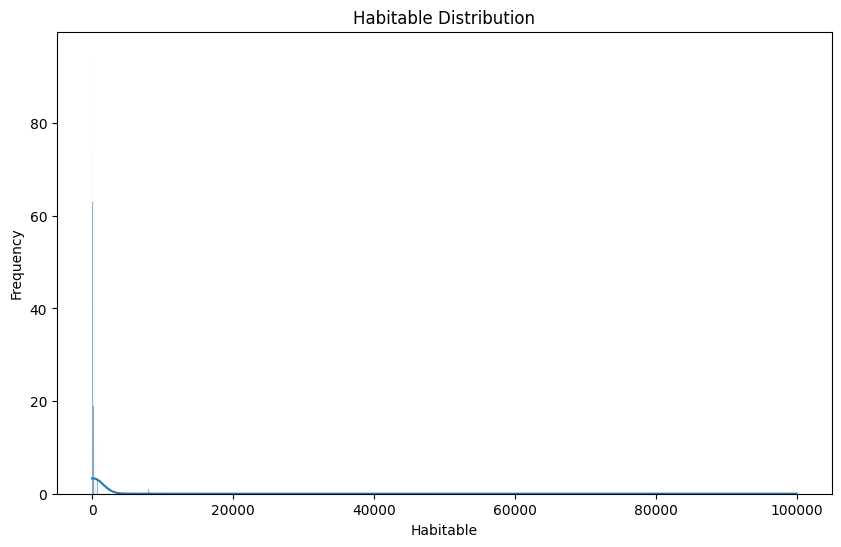

In [47]:
plot_distribution(df_clean['Habitable'],'Habitable Distribution','Habitable')

In [48]:
# Replace missing values with median since the distribution is skwed
df_clean['Habitable'].fillna(df_clean['Habitable'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\1680901862.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Habitable'].fillna(df_clean['Habitable'].median(), inplace=True)


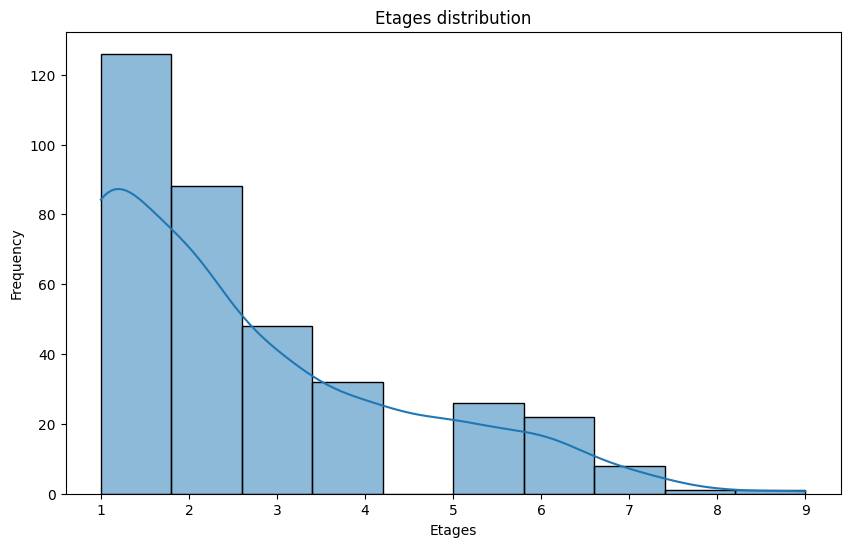

In [49]:
plot_distribution(df_clean['Etages'],'Etages distribution','Etages')

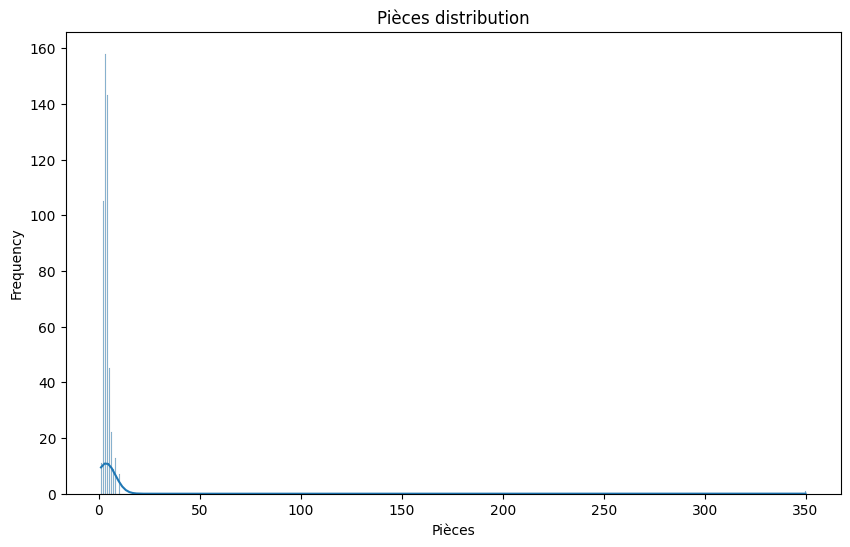

In [50]:
plot_distribution(df_clean['Pièces'],'Pièces distribution','Pièces')

In [51]:
# Replace missing values with median since the distribution is skwed
df_clean['Pièces'].fillna(df_clean['Pièces'].median(), inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\3906860705.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Pièces'].fillna(df_clean['Pièces'].median(), inplace=True)


In [52]:
df_clean = df_clean[df_clean['Pièces']<20]

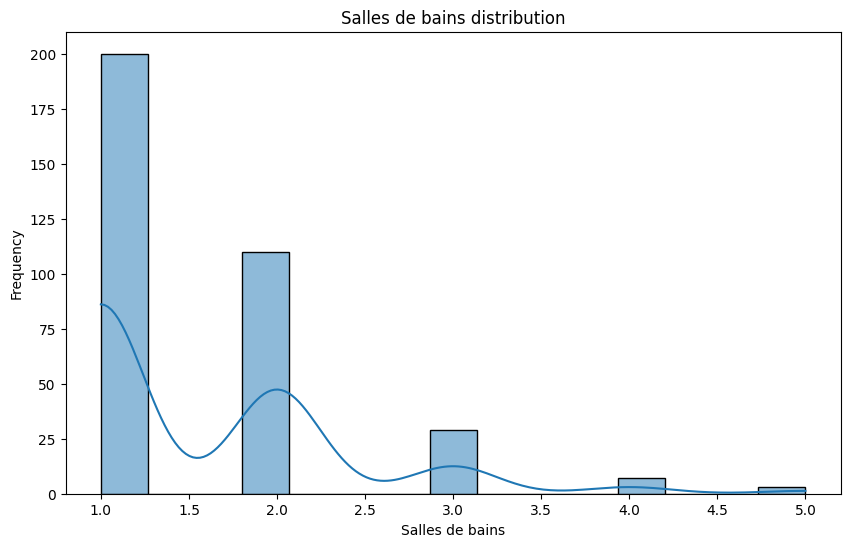

In [53]:
plot_distribution(df_clean['Salles de bains'],'Salles de bains distribution','Salles de bains')

In [54]:
# Replace missing values with mode since the distribution is categorical
df_clean['Salles de bains'].fillna(df_clean['Salles de bains'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\2135588293.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Salles de bains'].fillna(df_clean['Salles de bains'].mode()[0], inplace=True)


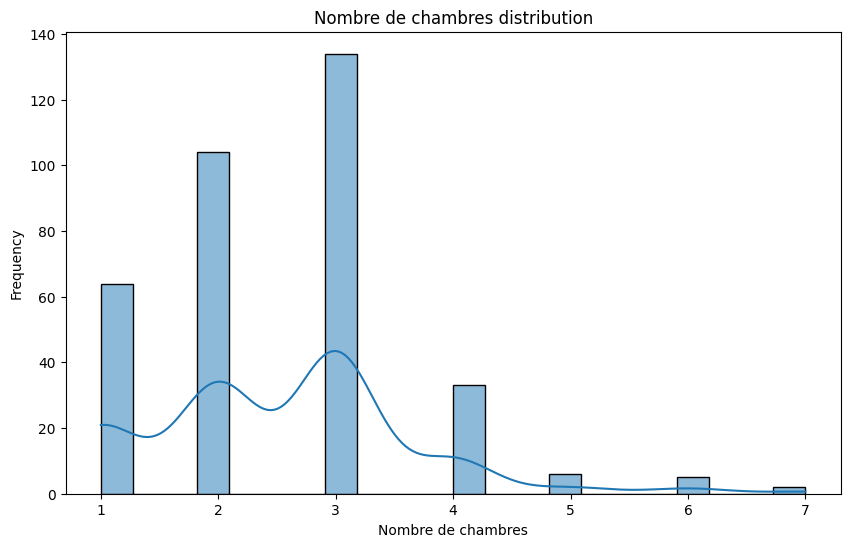

In [55]:
plot_distribution(df_clean['Chambres'],'Nombre de chambres distribution','Nombre de chambres')

In [56]:
# Replace missing values with mode since the distribution is categorical
df_clean['Chambres'].fillna(df_clean['Chambres'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\3383310863.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Chambres'].fillna(df_clean['Chambres'].mode()[0], inplace=True)


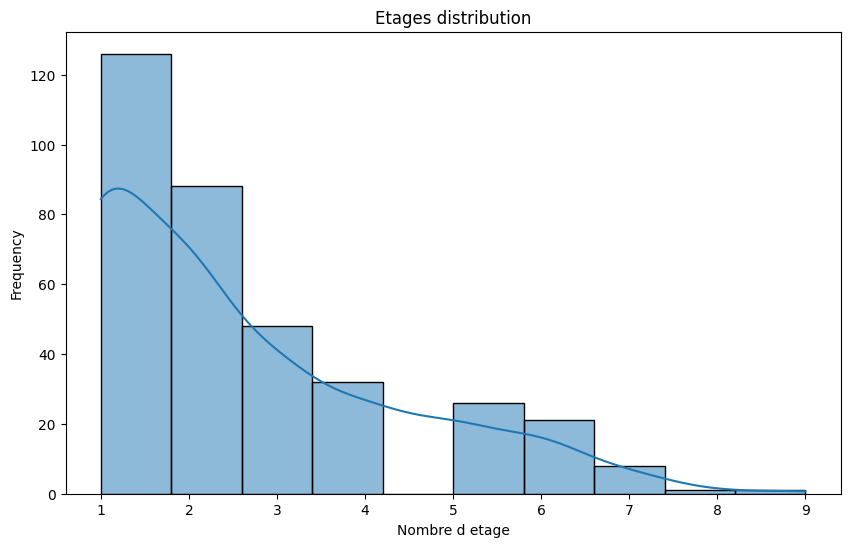

In [57]:
plot_distribution(df_clean['Etages'],'Etages distribution','Nombre d etage')

In [58]:
# Replace missing values with mode since the distribution is categorical
df_clean['Etages'].fillna(df_clean['Etages'].mode()[0], inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\1566603011.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Etages'].fillna(df_clean['Etages'].mode()[0], inplace=True)


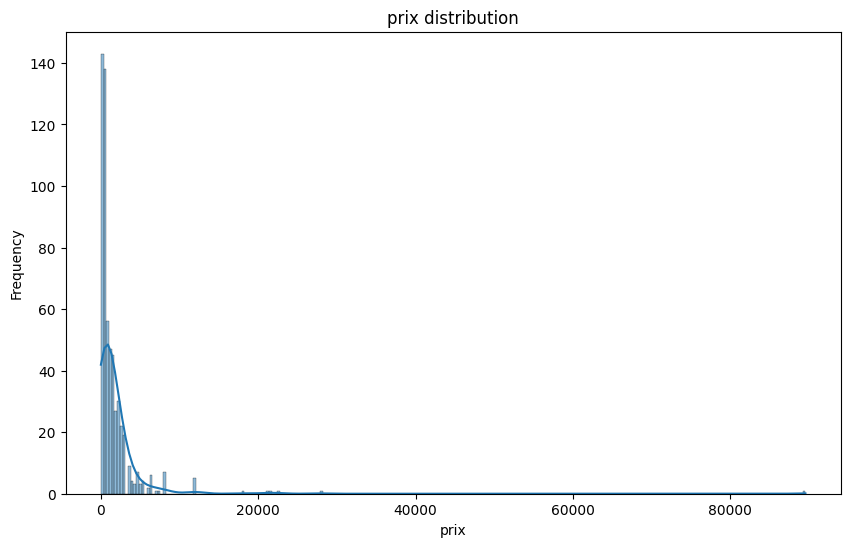

In [59]:
plot_distribution(df_clean['prix'],'prix distribution','prix')

In [60]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply to numerical columns
for col in ["prix", "Habitable", "Pièces"]:
    df_clean = remove_outliers_iqr(df_clean, col)


In [61]:
df_clean['prix'].describe()

count     441.000000
mean      909.603175
std       855.294598
min         0.000000
25%       301.000000
50%       542.000000
75%      1400.000000
max      3800.000000
Name: prix, dtype: float64

In [62]:
df_clean = df_clean[df_clean['prix'] > 0]

In [63]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 411 entries, 1 to 75
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Habitable        411 non-null    float64
 1   Pièces           411 non-null    float64
 2   Salles de bains  411 non-null    float64
 3   Chambres         411 non-null    float64
 4   Garage           411 non-null    int64  
 5   Jardin           411 non-null    int64  
 6   Balcon           411 non-null    int64  
 7   Meublé           411 non-null    int64  
 8   Piscine          411 non-null    int64  
 9   Etages           411 non-null    float64
 10  prix             411 non-null    float64
 11  Type             371 non-null    object 
 12  Latitude         411 non-null    float64
 13  Longitude        411 non-null    float64
dtypes: float64(8), int64(5), object(1)
memory usage: 48.2+ KB


### Columns correlation

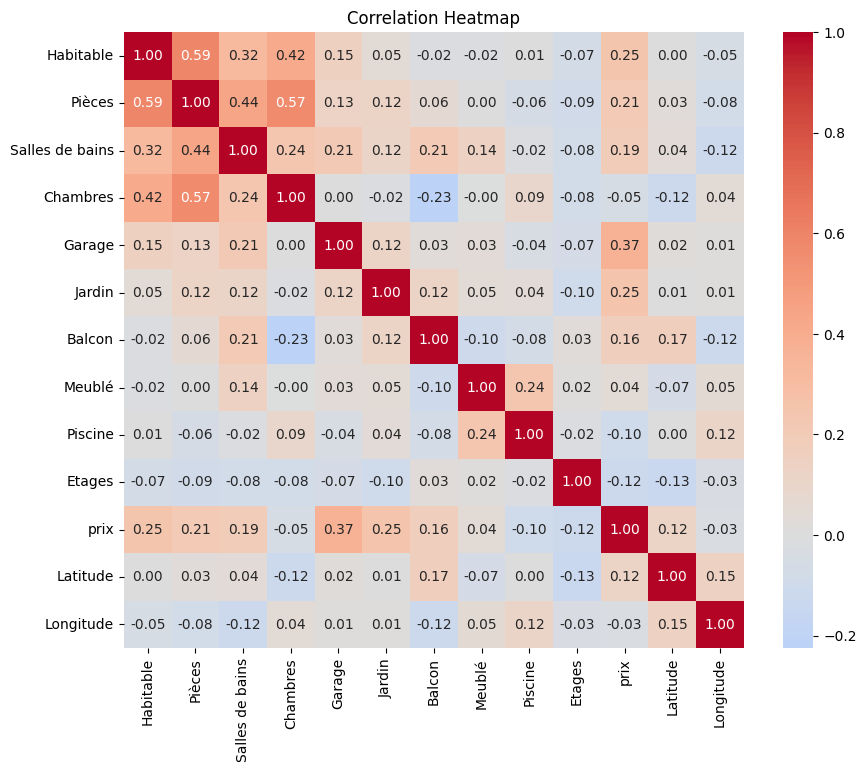

In [64]:
# Filter only numeric columns
df_numeric = df_clean.select_dtypes(include=["number"])

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)

# Display the heatmap
plt.title("Correlation Heatmap")
plt.show()


### Encoding

In [65]:
df_clean.head(1)

,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix,Type,Latitude,Longitude
1,100.0,3.0,1.0,2.0,0,0,1,0,0,3.0,1100.0,Residential,36.849148,10.263936


In [66]:
# Find the most frequent (mode) value
most_frequent = df_clean['Type'].mode()[0]
# Fill missing values with the most frequent value
df_clean['Type'].fillna(most_frequent, inplace=True)
df_encoded = pd.get_dummies(df_clean, columns=['Type'], drop_first=True)
df_encoded.head()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3764\2319487793.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Type'].fillna(most_frequent, inplace=True)


,Habitable,Pièces,Salles de bains,Chambres,Garage,Jardin,Balcon,Meublé,Piscine,Etages,prix,Latitude,Longitude,Type_Other,Type_Residential
1,100.0,3.0,1.0,2.0,0,0,1,0,0,3.0,1100.0,36.849148,10.263936,False,True
2,125.0,4.0,1.0,3.0,0,0,1,0,0,1.0,1250.0,36.874975,10.245427,False,True
3,196.0,4.0,1.0,3.0,0,0,0,1,0,3.0,3000.0,36.387609,9.801912,False,True
4,60.0,2.0,1.0,1.0,0,0,1,1,0,1.0,2200.0,36.887333,10.315343,False,True
5,159.0,3.0,1.0,3.0,0,0,0,1,0,1.0,3500.0,36.847856,10.265324,True,False


### Building the model

In [67]:
# Convert boolean columns to integer
bool_columns = ["Type_Other", "Type_Residential"]
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

In [68]:
syn_df=pd.read_csv('synthatic_location.csv')
syn_df=syn_df.drop(columns=['Unnamed: 0','Total'])
syn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Habitable         5000 non-null   float64
 1   Pièces            5000 non-null   float64
 2   Salles de bains   5000 non-null   float64
 3   Chambres          5000 non-null   float64
 4   Garage            5000 non-null   int64  
 5   Jardin            5000 non-null   int64  
 6   Balcon            5000 non-null   int64  
 7   Meublé            5000 non-null   int64  
 8   Piscine           5000 non-null   int64  
 9   Etages            5000 non-null   float64
 10  prix              5000 non-null   float64
 11  Latitude          5000 non-null   float64
 12  Longitude         5000 non-null   float64
 13  Type_Other        5000 non-null   int64  
 14  Type_Residential  5000 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 586.1 KB


In [69]:
final_df=pd.concat([df_encoded,syn_df])
X=final_df.drop(columns=['prix'])
y=final_df['prix']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
#final_df.to_csv('fnal_df_location.csv') we are gonna use it to generate synthatic data

In [71]:
# ✅ Define the model with the best hyperparameters
from sklearn.ensemble import GradientBoostingRegressor
sgb = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=6,
    min_samples_leaf=3,
    min_samples_split=20,
    n_estimators=700,
    subsample=0.8,
    random_state=42
)

# ✅ Train the model
sgb.fit(X_train, y_train)

# ✅ Predict on test data
y_pred = sgb.predict(X_test)

# ✅ Compute Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ✅ Print results
print(f"🔹 Real RMSE: {rmse:.2f}")
print(f"🔹 Mean Absolute Error: {mae:.2f}")
print(f"🔹 R² Score: {r2:.4f}")


🔹 Real RMSE: 138.70
🔹 Mean Absolute Error: 33.41
🔹 R² Score: 0.9720


### Download the model

In [178]:
with open('model_location','wb') as f:
    pickle.dump(sgb,f)